In [1]:
### basic
import sys
sys.path.append('../')
from config_sing import *

### specific tools
from collections import defaultdict
from functools import reduce
import itertools as it
import sqlite3
# https://stackoverflow.com/questions/49456158/integer-in-python-pandas-becomes-blob-binary-in-sqlite
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))

### file path of fragment database
fdiry = os.path.join(FD_RES, "KS91_K562_ASTARRseq", 'database')
fname = "fragment_astarr_gata1.db"
FPATH_DB_ASTARR = os.path.join(fdiry, fname)

fdiry = os.path.join(FD_RES, "Tewhey_K562_TileMPRA", 'database')
fname = "fragment_tilempra_gata1.db"
FPATH_DB_TMPRA = os.path.join(fdiry, fname)

FPATHS_DB = [FPATH_DB_ASTARR, FPATH_DB_TMPRA]

You are on Duke Server: Singularity: Proj ENCODE FCC
BASE DIRECTORY:     /mount/work
PATH OF SOURCE:     /mount/work/source
PATH OF EXECUTABLE: /mount/work/exe
PATH OF ANNOTATION: /mount/work/annotation
PATH OF PROJECT:    /mount/project
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc



In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
print(physical_devices)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from umap.parametric_umap import ParametricUMAP
from umap.parametric_umap import load_ParametricUMAP

In [4]:
fdiry = os.path.join(FD_RES, "regulatory_landscape")
fname = "dat_annot_TileMPRA.csv"
fpath = os.path.join(fdiry, fname)
dat_ant = pd.read_csv(fpath)

print(dat_ant.shape)
dat_ant.head()

(52312, 273)


,Fragment,Mtf_KLF/SP/2,Mtf_ZNF28,Mtf_FOX/4,Mtf_ZNF382,Mtf_ZNF136,Mtf_ZNF41,Mtf_IRF/1,Mtf_RUNX/2,Mtf_ZNF320,...,Mtf_BCL6/1,Mtf_MYB/4,Mtf_HD/1,Mtf_HIF,Mtf_ZNF306,Mtf_ZNF547,Mtf_ZNF713,Mtf_GMEB2/1,Mtf_HINFP1/2,Mtf_ZBED1
0,chrX_47786401_47786600,6.700100,15.9435,8.4743,24.6662,2.6078,7.1286,5.3024,8.9312,5.6607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chrX_47786951_47787150,5.008633,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chrX_47787001_47787200,11.829133,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chrX_47787051_47787250,11.829133,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chrX_47787101_47787300,11.829133,0.0000,8.8403,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
fdiry = os.path.join(FD_RES, "regulatory_landscape")
fname = "embedder_TileMPRA_trn_epochs_05.P"
fpath = os.path.join(fdiry, fname)

embedder = load_ParametricUMAP(fpath)

Pickle of ParametricUMAP model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/model.pkl
Keras encoder model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/encoder
Keras full model loaded from /mount/work/out/proj_combeffect_encode_fcc/regulatory_landscape/embedder_TileMPRA_trn_epochs_05.P/parametric_model


In [6]:
mat = dat_ant.drop(columns="Fragment").to_numpy()
print(dat_ant.shape)
print(mat.shape)

(52312, 273)
(52312, 272)


In [8]:
embedding = embedder.transform(mat)
print(embedding.shape)

(52312, 2)


In [13]:
np.random.seed(123)

n      = 100000
n_rows = embedding.shape[0]
idx    = np.arange(n_rows)
i      = np.random.choice(idx, size=n)

In [14]:
j = dat_ant.columns.str.startswith("Mtf_GATA")
c = dat_ant.iloc[i,j].values.ravel()
print(np.sum(j))

1


In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

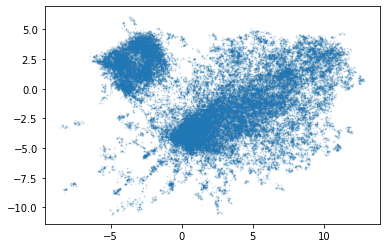

In [22]:
fig, ax = plt.subplots()
x = embedding[i,0]
y = embedding[i,1]
im = ax.scatter(x, y, s=0.5, alpha = 0.1)

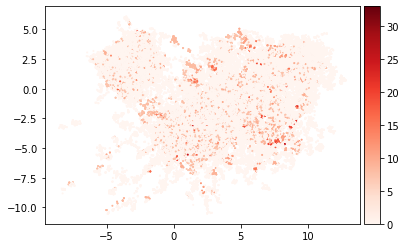

In [17]:
fig, ax = plt.subplots()
x = embedding[i,0]
y = embedding[i,1]
im = ax.scatter(x, y, s=1, c=c, cmap="Reds")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)

In [36]:
dat = dat_ant
dat[['Chrom', 'Start', 'End']] = dat['Fragment'].str.split('_', expand=True)
dat = dat.astype({"Start": int, "End": int})
dat = dat.assign(Mid = lambda x: np.ceil((x.Start + x.End) / 2))
dat = dat.astype({"Mid": int})
dat.head()

,Fragment,Mtf_KLF/SP/2,Mtf_ZNF28,Mtf_FOX/4,Mtf_ZNF382,Mtf_ZNF136,Mtf_ZNF41,Mtf_IRF/1,Mtf_RUNX/2,Mtf_ZNF320,...,Mtf_ZNF306,Mtf_ZNF547,Mtf_ZNF713,Mtf_GMEB2/1,Mtf_HINFP1/2,Mtf_ZBED1,Chrom,Start,End,Mid
0,chrX_47786401_47786600,6.700100,15.9435,8.4743,24.6662,2.6078,7.1286,5.3024,8.9312,5.6607,...,0.0,0.0,0.0,0.0,0.0,0.0,chrX,47786401,47786600,47786501
1,chrX_47786951_47787150,5.008633,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,chrX,47786951,47787150,47787051
2,chrX_47787001_47787200,11.829133,0.0000,8.4158,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,chrX,47787001,47787200,47787101
3,chrX_47787051_47787250,11.829133,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,chrX,47787051,47787250,47787151
4,chrX_47787101_47787300,11.829133,0.0000,8.8403,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,chrX,47787101,47787300,47787201


In [40]:
j = dat.columns.str.startswith("Mid")
c = dat.iloc[i,j].values.ravel()

In [41]:
c

array([48680481, 49079711, 48749951, ..., 48796751, 48809101, 48532211])

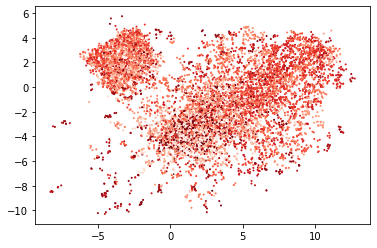

In [42]:
fig, ax = plt.subplots()
x = embedding[i,0]
y = embedding[i,1]
ax.scatter(x, y, s=1, c=c, cmap="Reds")